In [2]:
%matplotlib inline
from netCDF4 import Dataset as nc
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.gridspec as gridspec
import os
import sys
import pytz
from datetime import datetime, timedelta

### Define the input netCDF data
First define the experiment setup to construct the input files. The Experiment setup contains the following info:
 * domwain_name = Where took the experiment place
 * exp_id       = What is the parametrization setup
 * init_time    = The time of initialisation
 
Then define all the input-fields, where they are stored and the variable names
Also define the Experiment-setup to 

In [3]:
datadir = os.path.join(os.getenv('HOME'), 'Data', 'Extremes', 'UM')
domain_name = 'darwin'
exp_id = 'RA1T'
init_time = '20061110T0000Z'
modeldir = os.path.join(datadir, domain_name, exp_id, init_time)
timezone = pytz.timezone('Australia/Darwin')
utc = pytz.UTC

Now get all files model input and observations

In [4]:
cpolF = os.path.join(modeldir,'CPOL_2p5km_2006111000-2006111823.nc')
um044F = os.path.join(modeldir,'UM_0p44km_200611100-200611181200.nc')
um133F = os.path.join(modeldir,'UM_1p33km_200611100-200611181200.nc')

### Read the data with xarray define the smalest common area and get the common time-steps

In [5]:
cpol = xr.open_dataset(cpolF)
um044 = xr.open_dataset(um044F)
um133 = xr.open_dataset(um133F)

Round the times to the next 10 min

In [6]:
ns10min=10*60*1000000000   # 10 minutes in nanoseconds 
t1 = pd.to_datetime(((um133.t.astype(np.int64) // ns10min + 1 ) * ns10min))#.tz_localize(utc)
t2 = pd.to_datetime(((um044.t.astype(np.int64) // ns10min + 1 ) * ns10min))#.tz_localize(utc)
t3 = pd.to_datetime(((cpol.time.astype(np.int64) // ns10min + 1 ) * ns10min))#.tz_localize(utc)
um044['t'] = t2#.tz_convert(timezone)
um133['t'] = t1#.tz_convert(timezone)
cpol['time'] = t3#.tz_convert(timezone)

In [ ]:
um044.close()
um133.close()
cpol.close()

In [7]:
lons, lats, times = [], [], []
for dataset, lonn, latn, timen in ((cpol, 'longitude', 'latitude', 'time'),
                                  (um044, 'longitude', 'latitude', 't'),
                                  (um133, 'longitude', 'latitude', 't')):
    lon, lat, time = dataset[lonn].values, dataset[latn].values, dataset[timen].values
    lons.append((lon.min(), lon.max()))
    lats.append((lat.min(), lat.max()))
    times.append((time.min(), time.max()))
lons, lats, times = np.array(lons), np.array(lats), np.array(times, dtype='datetime64[m]')
domain_ko = dict(minlon=lons[:,0].max(), maxlon=lons[:,1].min(), maxlat=lats[:,1].min(), minlat=lats[:,0].max())
times = pd.date_range(times[:,0].max(), times[:,1].min(), freq='10 min')

### Define Tiwi-Islands

In [27]:
tiwilons = (130.024,131.58)
tiwilats = (-11.99,-11.083)

lons1_s, lons1_e = np.argmin(np.fabs(cpol['longitude'][0]-tiwilons[0])).values, np.argmin(np.fabs(cpol['longitude'][0]-tiwilons[1])).values
lons2_s, lons2_e = np.argmin(np.fabs(um133['longitude'][:]-tiwilons[0])).values, np.argmin(np.fabs(um133['longitude'][:]-tiwilons[1])).values
lons3_s, lons3_e = np.argmin(np.fabs(um044['longitude'][:]-tiwilons[0])).values, np.argmin(np.fabs(um044['longitude'][:]-tiwilons[1])).values

lats1_s, lats1_e = np.argmin(np.fabs(cpol['latitude'][:,0]-tiwilats[0])).values, np.argmin(np.fabs(cpol['latitude'][:,0]-tiwilats[1])).values
lats2_s, lats2_e = np.argmin(np.fabs(um133['latitude'][:]-tiwilats[0])).values, np.argmin(np.fabs(um133['latitude'][:]-tiwilats[1])).values
lats3_s, lats3_e = np.argmin(np.fabs(um044['latitude'][:]-tiwilats[0])).values, np.argmin(np.fabs(um044['latitude'][:]-tiwilats[1])).values


DF = {'CPOL':np.nanmean(cpol['radar_estimated_rain_rate'].loc[times[0]:times[-1]].values[:,lats1_s:lats1_e+1,lons1_s:lons1_e+1], axis=(1,2)),
      'UM 1.33km':um133['field1681'].loc[times[0]:times[-1]].values[:,lats2_s:lats2_e+1,lons2_s:lons2_e+1].mean(axis=(1,2)),
      'UM 0.44km':um044['field1681'].loc[times[0]:times[-1]].values[:,lats2_s:lats2_e+1,lons2_s:lons2_e+1].mean(axis=(1,2))}

### Create the map

 Creating Comparison-2006-11-10_0940.png ....    

/usr/lib/python3/dist-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


 Creating Comparison-2006-11-19_0330.png .... ok 


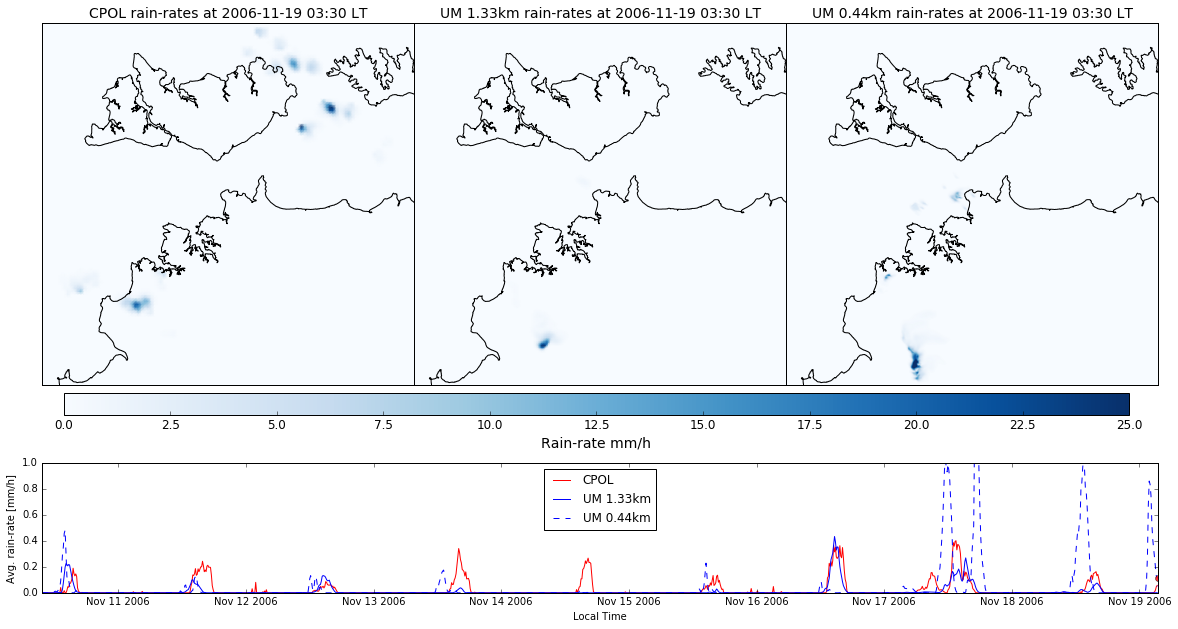

In [34]:
first = True
nn = 0
ii = nn
T = times[:].tz_localize(utc).tz_convert(timezone).to_pydatetime()
for t in times[nn:]:
    now = t.tz_localize(utc).tz_convert(timezone)
    tit1 = 'CPOL rain-rates at %s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    tit2 = 'UM 1.33km rain-rates at %s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    tit3 = 'UM 0.44km rain-rates at %s'%(now.strftime('%Y-%m-%d %H:%M LT'))
    

    data1 = np.ma.masked_less(cpol['radar_estimated_rain_rate'].loc[t],0.2).filled(0)
    data2 = np.ma.masked_less(um133['field1681'].loc[t]*100.,0.2).filled(0)
    data3 = np.ma.masked_less(um044['field1681'].loc[t]*100.,0.2).filled(0)
    
    
    
    fname = os.path.join(modeldir,'Comparison-%s.png'%(now.strftime('%Y-%m-%d_%H%M')))
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s ....    '%os.path.basename(fname))
    sys.stdout.flush()
    if first:
        fig = plt.figure(figsize=(20,15), dpi=72)
        gs = gridspec.GridSpec(2, 3, height_ratios=[4, 1])
                       #width_ratios=[1, 1],
                       #height_ratios=[1, 1]
                       #)
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[0, 1])
        ax3 = plt.subplot(gs[0, 2])
        ax4 = plt.subplot(gs[-1,:])

        m1 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax1)
        m2 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax2)
        m3 = Basemap(llcrnrlon=domain_ko['minlon'], urcrnrlon=domain_ko['maxlon'], llcrnrlat=domain_ko['minlat'],
                     urcrnrlat=domain_ko['maxlat'], resolution='f', area_thresh=100., ax = ax3)
        im1 = m1.pcolormesh(cpol['longitude'], cpol['latitude'], data1, vmin=0.0, vmax=25., cmap='Blues',
                              shading='gouraud')
        im2 = m2.pcolormesh(um133['longitude'], um133['latitude'], data2, vmin=0.0, vmax=25., cmap='Blues',
                              shading='gouraud')
        im3 = m3.pcolormesh(um044['longitude'], um044['latitude'], data3, vmin=0.0, vmax=25., cmap='Blues',
                              shading='gouraud')

        ax4.plot(T[nn:ii], DF['CPOL'][nn:ii], 'r-', label='CPOL')
        ax4.plot(T[nn:ii], DF['UM 1.33km'][nn:ii]*100, 'b-', label='UM 1.33km')
        ax4.plot(T[nn:ii], DF['UM 0.44km'][nn:ii]*100, 'b--', label='UM 0.44km')
        ax4.plot(T[nn:], DF['CPOL'][ii:], 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 1.33km'][ii:]*100, 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 0.44km'][ii:]*100, 'k--', alpha=0.2)
        
        ax4.plot(T[ii], DF['CPOL'][ii], marker='o',color='r', alpha=0.8)
        ax4.plot(T[ii], DF['UM 1.33km'][ii]*100, marker='1', color='b', alpha=0.8)
        ax4.plot(T[ii], DF['UM 0.44km'][ii]*100, marker='2', color='b', alpha=0.8)
        
        ax4.legend(loc=9)
        ax4.set_ylabel('Avg. rain-rate [mm/h]')
        ax4.set_ylim((0,1))
        ax4.set_xlabel('Local Time')
        
        m1.drawcoastlines()
        m2.drawcoastlines()
        m3.drawcoastlines()
        
        fig.subplots_adjust(bottom=0.01, hspace=0.0, wspace=0.0)
        gs.update(bottom=0.3,wspace=0.0, hspace=0.0)
        cbar_ax = fig.add_axes([0.14, 0.465, 0.74, 0.02])
        cbar=fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('Rain-rate mm/h',size=14)
        cbar.ax.tick_params(labelsize=12)
        first = False
    else:
        ax4.clear()
        ax4.plot(T[nn:ii], DF['CPOL'][nn:ii], 'r-', label='CPOL')
        ax4.plot(T[nn:ii], DF['UM 1.33km'][nn:ii]*100, 'b-', label='UM 1.33km')
        ax4.plot(T[nn:ii], DF['UM 0.44km'][nn:ii]*100, 'b--', label='UM 0.44km')
        ax4.plot(T[nn:], DF['CPOL'][ii:], 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 1.33km'][ii:]*100, 'k-', alpha=0.2)
        ax4.plot(T[nn:], DF['UM 0.44km'][ii:]*100, 'k--', alpha=0.2)
        
        ax4.plot(T[ii], DF['CPOL'][ii], marker='o',color='r', alpha=0.8)
        ax4.plot(T[ii], DF['UM 1.33km'][ii]*100, marker='1', color='b', alpha=0.8)
        ax4.plot(T[ii], DF['UM 0.44km'][ii]*100, marker='2', color='b', alpha=0.8)
        ax4.legend(loc=9)
        ax4.set_ylabel('Avg. rain-rate [mm/h]')
        ax4.set_ylim((0,1))
        ax4.set_xlabel('Local Time')
        for im, data in ((im1, data1), (im2, data2), (im3, data3)):
            im.set_array(data.ravel())
    ax1.set_title(tit1,size=14)
    ax2.set_title(tit2,size=14)
    ax3.set_title(tit3,size=14)
    
    fig.savefig(fname, bbox_inches='tight', format='png')
    #ax4.cla()
    ii += 1
    #break
    sys.stdout.flush()
    sys.stdout.write('\r Creating %s .... ok'%os.path.basename(fname))
    sys.stdout.flush()
sys.stdout.write('\n')